In [1]:
%matplotlib inline
import pylab as plt
import numpy as np
from astrometry.util.fits import fits_table, merge_tables
from glob import glob
import fitsio
import sys
import os
import tractor
from tractor.constrained_optimizer import ConstrainedOptimizer
import matplotlib
matplotlib.rcParams['figure.figsize'] = 10,8
from scipy.ndimage.filters import gaussian_filter

In [2]:
from gfa_metrology_ss import gfa_spreadsheets, gif_spreadsheets

In [3]:
def blanton_noise(img):
    # Estimate per-pixel noise via Blanton's 5-pixel MAD
    slice1 = (slice(0,-5,10),slice(0,-5,10))
    slice2 = (slice(5,None,10),slice(5,None,10))
    mad = np.median(np.abs(img[slice1] - img[slice2]).ravel())
    sig1 = 1.4826 * mad / np.sqrt(2.)
    return sig1

def measure_gfa_spots(imgdir, G_orig, plots=True, chatty=True):
    G = G_orig.copy()

    def chat(*X):
        if chatty:
            print(*X)

    bgfn = None
    I = np.flatnonzero(G.is_bg)
    if len(I):
        print(len(I), 'background images')
        bgfn = G[I[0]].img_fn
        G.cut(np.logical_not(G.is_bg))

    G.measx = np.zeros(len(G), np.float32)
    G.measy = np.zeros(len(G), np.float32)
    G.prescan = np.zeros(len(G), np.uint8)
    G.overscan = np.zeros(len(G), np.uint8)
    G.quadrant = np.zeros(len(G), np.uint8)

    if bgfn is None:
        # Use median of images rather than a background image?
        print('Estimating background from median of observations')
        bgimgs = []
        # for each extension...
        for i in range(1,5):
            stack = []
            for fn in G.img_fn:
                pth = os.path.join(imgdir, fn)
                if not os.path.exists(pth):
                    print('Image', fn, 'does not exist!')
                    continue
                img = fitsio.read(pth, ext=i)
                stack.append(img)
            stack = np.dstack(stack)
            bgimgs.append(np.median(stack, axis=2))
    else:
        bg = os.path.join(imgdir, bgfn)
        Fbg = fitsio.FITS(bg)
        bgimgs = [Fbg[i].read() for i in range(1,5)]
    ima = dict(interpolation='nearest', origin='lower')
    
    all_coords = []
    print('Measuring spots in', len(G), 'images')
    for iimg,imgfn in enumerate(G.img_fn):
        chat()
        chat('Image', imgfn)
        fn = os.path.join(imgdir, imgfn) #'IMG_%i.fits' % imgnum)
        if not os.path.exists(fn):
            # Try .fit -> .fits
            if os.path.exists(fn + 's'):
                fn += 's'
            else:
                print('Image', imgfn, 'does not exist!')
                continue
        F = fitsio.FITS(fn)
        hdr = F[0].read_header()
        prescan = hdr['PRESCAN']
        overscan = hdr['OVERSCAN']
        #print('Prescan', prescan, 'overscan', overscan)
        bestsn = 0.
        for q in range(4):
            img = F[q+1].read()
            hi,wi = img.shape
            active = (img - bgimgs[q])[:, prescan:-overscan]
            #print('Active area:', active.shape)

            active = active - np.median(active)
            ah,aw = active.shape
            sig1 = blanton_noise(active)

            # Mask 8 bad rows at the bottom
            active[:8,:] = 0.
            
            smoo = gaussian_filter(active, 2.)
            noise = blanton_noise(smoo)
            maxsn = np.max(smoo/noise)
            chat('S/N', maxsn)
            imax = np.argmax(smoo/noise)
            i,j = np.unravel_index(imax, smoo.shape)

            if plots:
                plt.clf()
                plt.imshow(active, vmin=-3.*sig1, vmax=20.*sig1, **ima)
                ax = plt.axis()
                plt.plot(j, i, 'o', mec='r', ms=20, mfc='none')
                plt.show()
            
            if maxsn < 2000:
                continue
            if maxsn < bestsn:
                continue
            chat('At', j,i)
            if i<10 or j<10:
                chat('Too close to edge')
                continue
            bestsn = maxsn
            cutout = active[i-10:i+11, j-10:j+11]

            SAT = 25000
        
            satur = (cutout > SAT)
            inverr = np.ones_like(cutout) / sig1
            inverr[satur] = 0.
        
            tim = tractor.Image(data=cutout, inverr=inverr,
                               psf=tractor.NCircularGaussianPSF([2.], [1.]))
            src = tractor.PointSource(tractor.PixPos(10, 10), tractor.Flux(np.sum(cutout)))
            tr = tractor.Tractor([tim], [src], optimizer=ConstrainedOptimizer())
            tr.freezeParam('images')
            tr.optimize_loop()
            #tr.printThawedParams()
            tr.thawParam('images')
            tim.freezeAllBut('psf')
            tim.psf.freezeParam('weights')
            tr.optimize_loop()
            #tr.printThawedParams()
            ox = src.pos.x + j - 10
            oy = src.pos.y + i - 10
            chat('Optimized position: (%.1f, %.1f)' % (ox, oy))

            G.measx[iimg] = ox
            G.measy[iimg] = oy
            G.prescan[iimg] = prescan
            G.overscan[iimg] = overscan
            G.quadrant[iimg] = q+1
            
            #plt.imshow(active, **ima)
            #plt.show()
            if plots:
                plt.clf()
                plt.subplot(2,2,1)
                mod = tr.getModelImage(0)
                mx = max(max(np.minimum(mod, SAT).ravel()), max(cutout.ravel()))
                cima = ima.copy()
                cima.update(vmin=cutout.min(), vmax=mx)
                plt.imshow(cutout, **cima)
                plt.xticks([]); plt.yticks([])
                plt.subplot(2,2,2)
                plt.imshow(mod, **cima)
                plt.xticks([]); plt.yticks([])
                plt.subplot(2,2,3)
                plt.imshow(tr.getChiImage(0), **ima)
                plt.xticks([]); plt.yticks([])
                plt.subplot(2,2,4)
                plt.plot(cutout[:,10], color='b', alpha=0.5, lw=5)
                plt.plot(cutout[10,:], color='g', alpha=0.5, lw=5)
                plt.plot(mod[:,10], color='b')
                plt.plot(mod[10,:], color='g')
                plt.show()

    G.ssx = np.zeros(len(G), np.float32)
    G.ssy = np.zeros(len(G), np.float32)

    I = np.array([q in [1,4] for q in G.quadrant])
    G.ssx[I] = G.measx[I] + G.prescan[I]
    I = np.array([q in [2,3] for q in G.quadrant])
    G.ssx[I] = 2048 - G.measx[I] + G.prescan[I] + 2 * G.overscan[I]

    I = np.array([q in [1,2] for q in G.quadrant])
    G.ssy[I] = 1056*2 - G.measy[I]
    I = np.array([q in [3,4] for q in G.quadrant])
    G.ssy[I] = G.measy[I]

    G.mtnx = np.zeros(len(G), np.float32)
    G.mtny = np.zeros(len(G), np.float32)

    I = np.array([q in [1,4] for q in G.quadrant])
    G.mtnx[I] = G.measx[I]
    I = np.array([q in [2,3] for q in G.quadrant])
    G.mtnx[I] = 2047 - G.measx[I]

    I = np.array([q in [1,2] for q in G.quadrant])
    G.mtny[I] = 2063 - G.measy[I]
    I = np.array([q in [3,4] for q in G.quadrant])
    G.mtny[I] = G.measy[I]

    # The above 'livey' is in the range [0, 2063], ie the real CCD area, but on the mountain,
    # there is a mask for the frame transfer; exposed area is half that, 1032.
    G.mtny -= 1032/2

    # Switch to FITS pixel indexing here --
    G.mtnx += 1.0
    G.mtny += 1.0
    
    Igood = np.flatnonzero(G.quadrant > 0)
    N = len(Igood)
    A = np.zeros((N,3))
    A[:,0] = 1.
    A[:,1] = G.mmx[Igood]
    A[:,2] = G.mmy[Igood]
    r = np.linalg.lstsq(A, G.mtnx[Igood], rcond=None)
    cx = r[0]
    r = np.linalg.lstsq(A, G.mtny[Igood], rcond=None)
    cy = r[0]

    G.fitx = (cx[0] + G.mmx*cx[1] + G.mmy*cx[2]).astype(np.float32)
    G.fity = (cy[0] + G.mmx*cy[1] + G.mmy*cy[2]).astype(np.float32)

    # pix to mm
    A[:,1] = G.mtnx[Igood]
    A[:,2] = G.mtny[Igood]
    r = np.linalg.lstsq(A, G.mmx[Igood], rcond=None)
    px = r[0]
    r = np.linalg.lstsq(A, G.mmy[Igood], rcond=None)
    py = r[0]

    G.fit_mm_x = (px[0] + G.mtnx*px[1] + G.mtny*px[2]).astype(np.float32)
    G.fit_mm_y = (py[0] + G.mtnx*py[1] + G.mtny*py[2]).astype(np.float32)
    
    r = np.hypot(G.orig_ssx[Igood] - G.ssx[Igood], G.orig_ssy[Igood] - G.ssy[Igood])
    print('Scatter from spreadsheet to measured pixel positions: %.1f pixels' %
          np.mean(r))
    if np.mean(r) > 2.:
        imx = np.argmax(r)
        ii = Igood[imx]
        print('Largest difference: ss (%.1f,%.1f) vs meas (%.1f, %.1f)' % (G.orig_ssx[ii], G.orig_ssy[ii], G.ssx[ii], G.ssy[ii]))
    print('Scatter from measured to fit positions: %.1f pixels' %
          np.mean(np.hypot(G.mtnx[Igood] - G.fitx[Igood], G.mtny[Igood] - G.fity[Igood])))
    print('Scatter from measured to fit positions: %.3f mm' %
          np.mean(np.hypot(G.mmx[Igood] - G.fit_mm_x[Igood], G.mmy[Igood] - G.fit_mm_y[Igood])))
    nbad = np.sum(G.quadrant == 0)
    if nbad:
        print('Failed to measure a spot in', nbad, 'images:', G.img_fn[G.quadrant == 0])
    return G, cx, cy, px, py

In [4]:
# Run and create FITS tables of results

GG = []
T = fits_table()
Ngfa = 6
Ngifs = 4
T.gfa_num = np.zeros(Ngfa, np.uint8)
T.pix_x_coeffs = np.zeros((Ngfa,3), np.float32)
T.pix_y_coeffs = np.zeros((Ngfa,3), np.float32)
T.mm_x_coeffs = np.zeros((Ngfa,3), np.float32)
T.mm_y_coeffs = np.zeros((Ngfa,3), np.float32)
T.gif_1_pix_x = np.zeros((Ngfa,Ngifs), np.float32)
T.gif_1_pix_y = np.zeros((Ngfa,Ngifs), np.float32)
T.gif_2_pix_x = np.zeros((Ngfa,Ngifs), np.float32)
T.gif_2_pix_y = np.zeros((Ngfa,Ngifs), np.float32)
T.gif_1_mm_x = np.zeros((Ngfa,Ngifs), np.float32)
T.gif_1_mm_y = np.zeros((Ngfa,Ngifs), np.float32)
T.gif_2_mm_x = np.zeros((Ngfa,Ngifs), np.float32)
T.gif_2_mm_y = np.zeros((Ngfa,Ngifs), np.float32)

for i,gfanum in enumerate([10, 6, 2, 8, 1, 4]):
    print('GFA #',gfanum)
    G,tx,ty,rx,ry = measure_gfa_spots('gfa-metrology-images/%i'%gfanum, gfa_spreadsheets[gfanum], plots=False, chatty=False)
    G.gfa_num = np.zeros(len(G), np.uint8) + gfanum
    GG.append(G)

    T.gfa_num[i] = gfanum
    T.pix_x_coeffs[i,:] = tx
    T.pix_y_coeffs[i,:] = ty
    T.mm_x_coeffs[i,:] = rx
    T.mm_y_coeffs[i,:] = ry
    gif1,gif2 = gif_spreadsheets[gfanum]
    px1 = tx[0] + gif1.x*tx[1] + gif1.y*tx[2]
    py1 = ty[0] + gif1.x*ty[1] + gif1.y*ty[2]
    px2 = tx[0] + gif2.x*tx[1] + gif2.y*tx[2]
    py2 = ty[0] + gif2.x*ty[1] + gif2.y*ty[2]
    T.gif_1_pix_x[i] = px1
    T.gif_1_pix_y[i] = py1
    T.gif_2_pix_x[i] = px2
    T.gif_2_pix_y[i] = py2
    T.gif_1_mm_x[i] = gif1.x
    T.gif_1_mm_y[i] = gif1.y
    T.gif_2_mm_x[i] = gif2.x
    T.gif_2_mm_y[i] = gif2.y

GG = merge_tables(GG)
GG.writeto('gfa-metrology-measurements.fits')
T.writeto('gfa-metrology-transforms.fits')

GFA # 10
1 background images
Measuring spots in 12 images
Scatter from spreadsheet to measured pixel positions: 1.0 pixels
Scatter from measured to fit positions: 0.2 pixels
Scatter from measured to fit positions: 0.003 mm
GFA # 6
1 background images
Measuring spots in 12 images
Scatter from spreadsheet to measured pixel positions: 1.0 pixels
Scatter from measured to fit positions: 0.2 pixels
Scatter from measured to fit positions: 0.004 mm
GFA # 2
Estimating background from median of observations
Measuring spots in 12 images
Scatter from spreadsheet to measured pixel positions: 8.0 pixels
Largest difference: ss (1013.0,1548.0) vs meas (1013.2, 1459.3)
Scatter from measured to fit positions: 0.3 pixels
Scatter from measured to fit positions: 0.005 mm
GFA # 8
1 background images
Measuring spots in 12 images
Scatter from spreadsheet to measured pixel positions: 1.0 pixels
Scatter from measured to fit positions: 0.2 pixels
Scatter from measured to fit positions: 0.004 mm
GFA # 1
Estimatin

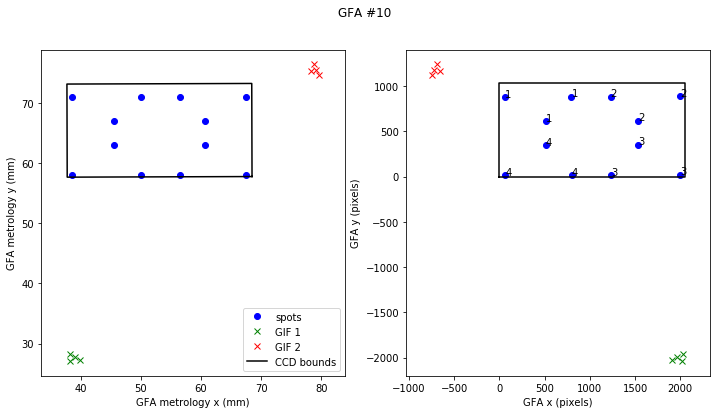

In [5]:
gfa_num = 10
G = GG[GG.gfa_num == gfa_num]
Ti = T[T.gfa_num == gfa_num][0]

plt.figure(figsize=(12,6))
# bounds of CCD
w,h = 2048, 1032
# to the edges of the pixels:
pbx = np.array([0.5,w+0.5,w+0.5,0.5,0.5])
pby = np.array([0.5,0.5,h+0.5,h+0.5,0.5])
pbxmm = Ti.mm_x_coeffs[0] + Ti.mm_x_coeffs[1]*pbx + Ti.mm_x_coeffs[2]*pby
pbymm = Ti.mm_y_coeffs[0] + Ti.mm_y_coeffs[1]*pbx + Ti.mm_y_coeffs[2]*pby

plt.subplot(1,2,1)
plt.plot(G.mmx, G.mmy, 'bo', label='spots');
plt.plot(Ti.gif_1_mm_x, Ti.gif_1_mm_y, 'gx', label='GIF 1')
plt.plot(Ti.gif_2_mm_x, Ti.gif_2_mm_y, 'rx', label='GIF 2')
plt.plot(pbxmm, pbymm, 'k-', label='CCD bounds')
plt.xlabel('GFA metrology x (mm)')
plt.ylabel('GFA metrology y (mm)')
plt.axis('equal')
plt.legend()

plt.subplot(1,2,2)
plt.plot(G.mtnx, G.mtny, 'bo');
for x,y,q in zip(G.mtnx, G.mtny, G.quadrant):
    plt.text(x,y,'%i'%q)
plt.plot(Ti.gif_1_pix_x, Ti.gif_1_pix_y, 'gx')
plt.plot(Ti.gif_2_pix_x, Ti.gif_2_pix_y, 'rx')
plt.plot(pbx, pby, 'k-')
plt.xlabel('GFA x (pixels)')
plt.ylabel('GFA y (pixels)')
plt.axis('equal')

plt.suptitle('GFA #%i' % gfa_num);